In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
#Batch Size 
batch_size = 128
image_size = 64
workers = 2

numchannels = 3 #Number of channels 
latent = 100 #Latent Space Size 
gen_feat = 64 # Size of feature maps in generator 
dis_feat = 64 # Size of feature maps in discriminator 

# Number of gpus available. Use 0 for cpu.
num_gpu = 0 

In [3]:
import os

def count_files_in_folder(folder_path):
    # Check if the folder exists
    if not os.path.isdir(folder_path):
        print("Error: The specified path is not a directory.")
        return
    
    # Initialize a counter for files
    file_count = 0
    
    # Iterate over files in the folder
    for _, _, files in os.walk(folder_path):
        file_count += len(files)
    
    return file_count

# Example usage
folder_path = '/Users/kiranprasadjp/Downloads/24789_hw2/img_align_celeba2/img_align_celeba'  # Replace this with the path to your folder
num_files = count_files_in_folder(folder_path)
print("Number of files in folder:", num_files)


Number of files in folder: 49736


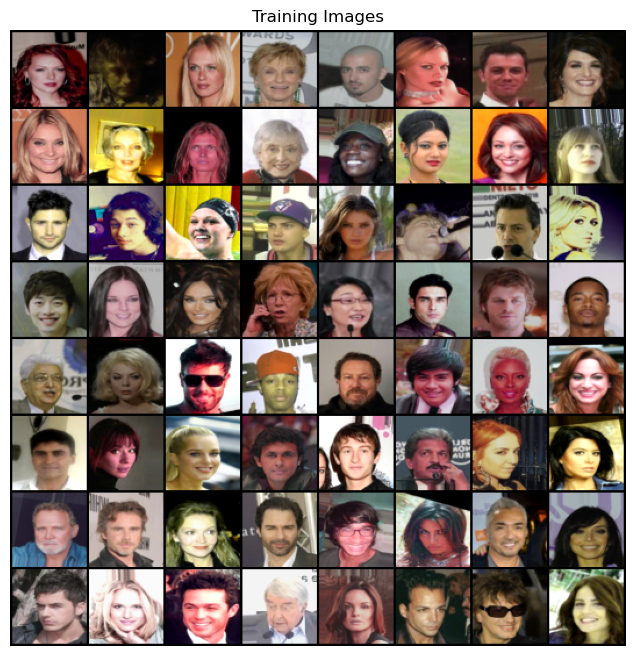

In [4]:
#Impliment data transforms and loading

#TODO

dataroot = '/Users/kiranprasadjp/Downloads/24789_hw2/img_align_celeba2'  # Add your file path here

transform = transforms.Compose([
    transforms.RandomResizedCrop(size=image_size, scale=(0.8, 1.0)),  # Random resized crop for data augmentation
    transforms.RandomHorizontalFlip(),  # Random horizontal flip for data augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize image tensors
])


dataset = dset.ImageFolder(root=dataroot, transform=transform)

# Create the dataloader
#TODO
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)#Add dataloader

#Select device
device = torch.device("cuda:0" if (torch.cuda.is_available() and num_gpu > 0) else "cpu")

#Display real images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
#Weight initialization for Generator and Discriminator no changes required 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, Num_GPU):
        super(Generator, self).__init__()
        self.Num_GPU = Num_GPU
        self.main = nn.Sequential(
            nn.ConvTranspose2d( latent, gen_feat * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gen_feat * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(gen_feat * 8, gen_feat * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feat * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( gen_feat * 4, gen_feat * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feat * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( gen_feat * 2, gen_feat, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feat),
            nn.ReLU(True),
            nn.ConvTranspose2d( gen_feat, numchannels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the generator
netG = Generator(num_gpu).to(device)

#Device selection
if (device.type == 'cuda') and (num_gpu > 1):
    netG = nn.DataParallel(netG, list(range(num_gpu)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
class Discriminator(nn.Module):
    def __init__(self, Num_GPU):
        super(Discriminator, self).__init__()
        self.Num_GPU = Num_GPU
        self.main = nn.Sequential(
            nn.Conv2d(numchannels, dis_feat, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_feat, dis_feat * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feat * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_feat * 2, dis_feat * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feat * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_feat * 4, dis_feat * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feat * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_feat * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the Discriminator
netD = Discriminator(num_gpu).to(device)

#Device Selection
if (device.type == 'cuda') and (num_gpu > 1):
    netD = nn.DataParallel(netD, list(range(num_gpu)))

netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [12]:
#Select Loss Function
#TODO
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, latent, 1, 1, device=device)

#Real and fake labels for training
real_label = 1
fake_label = 0
# Training Parameters
num_epochs = 15
lr = 0.005
beta1 = 0.5

# Setup optimizers for Generator and Discriminator
#TODO
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [13]:


# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ## Train with all-real batch
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        # Train with fake batch
        noise = torch.randn(b_size, latent, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        # (2) Update Generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        #Record Losses to Plot
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/15][0/389]	Loss_D: 1.5889	Loss_G: 40.8788	D(x): 0.4906	D(G(z)): 0.4655 / 0.0000
[0/15][50/389]	Loss_D: 2.4725	Loss_G: 1.1730	D(x): 0.6981	D(G(z)): 0.6154 / 0.4720
[0/15][100/389]	Loss_D: 1.5239	Loss_G: 3.7505	D(x): 0.7592	D(G(z)): 0.5569 / 0.1842
[0/15][150/389]	Loss_D: 1.5549	Loss_G: 1.3525	D(x): 0.4715	D(G(z)): 0.3259 / 0.3580
[0/15][200/389]	Loss_D: 0.9973	Loss_G: 2.3349	D(x): 0.6270	D(G(z)): 0.3014 / 0.1841
[0/15][250/389]	Loss_D: 1.5971	Loss_G: 2.6050	D(x): 0.9189	D(G(z)): 0.6776 / 0.1195
[0/15][300/389]	Loss_D: 1.2378	Loss_G: 1.5193	D(x): 0.4971	D(G(z)): 0.2584 / 0.2654
[0/15][350/389]	Loss_D: 1.2052	Loss_G: 2.1526	D(x): 0.6284	D(G(z)): 0.4068 / 0.1858
[1/15][0/389]	Loss_D: 1.3402	Loss_G: 1.7867	D(x): 0.6186	D(G(z)): 0.4488 / 0.2181
[1/15][50/389]	Loss_D: 1.1998	Loss_G: 2.0593	D(x): 0.5642	D(G(z)): 0.3609 / 0.1795
[1/15][100/389]	Loss_D: 1.3664	Loss_G: 1.3763	D(x): 0.4036	D(G(z)): 0.2528 / 0.2872
[1/15][150/389]	Loss_D: 0.9972	Loss_G: 2.6282	D(x): 0.7

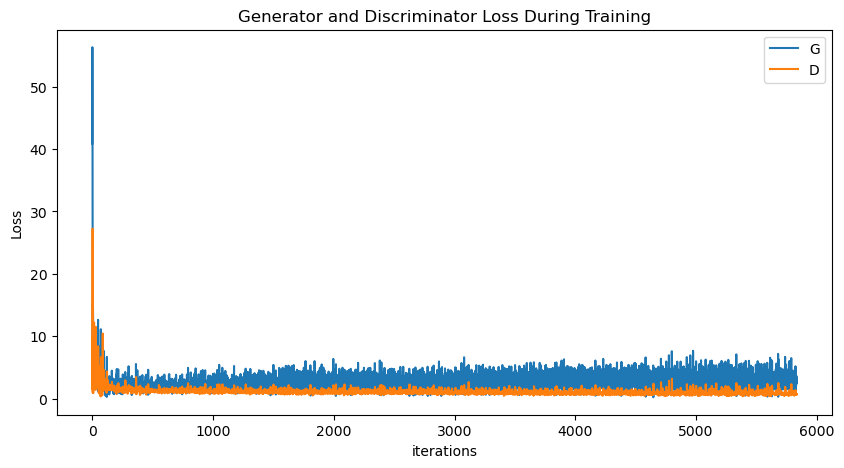

In [14]:
#Plot Your Generator and Discriminator Loss
#No Changes Needed
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

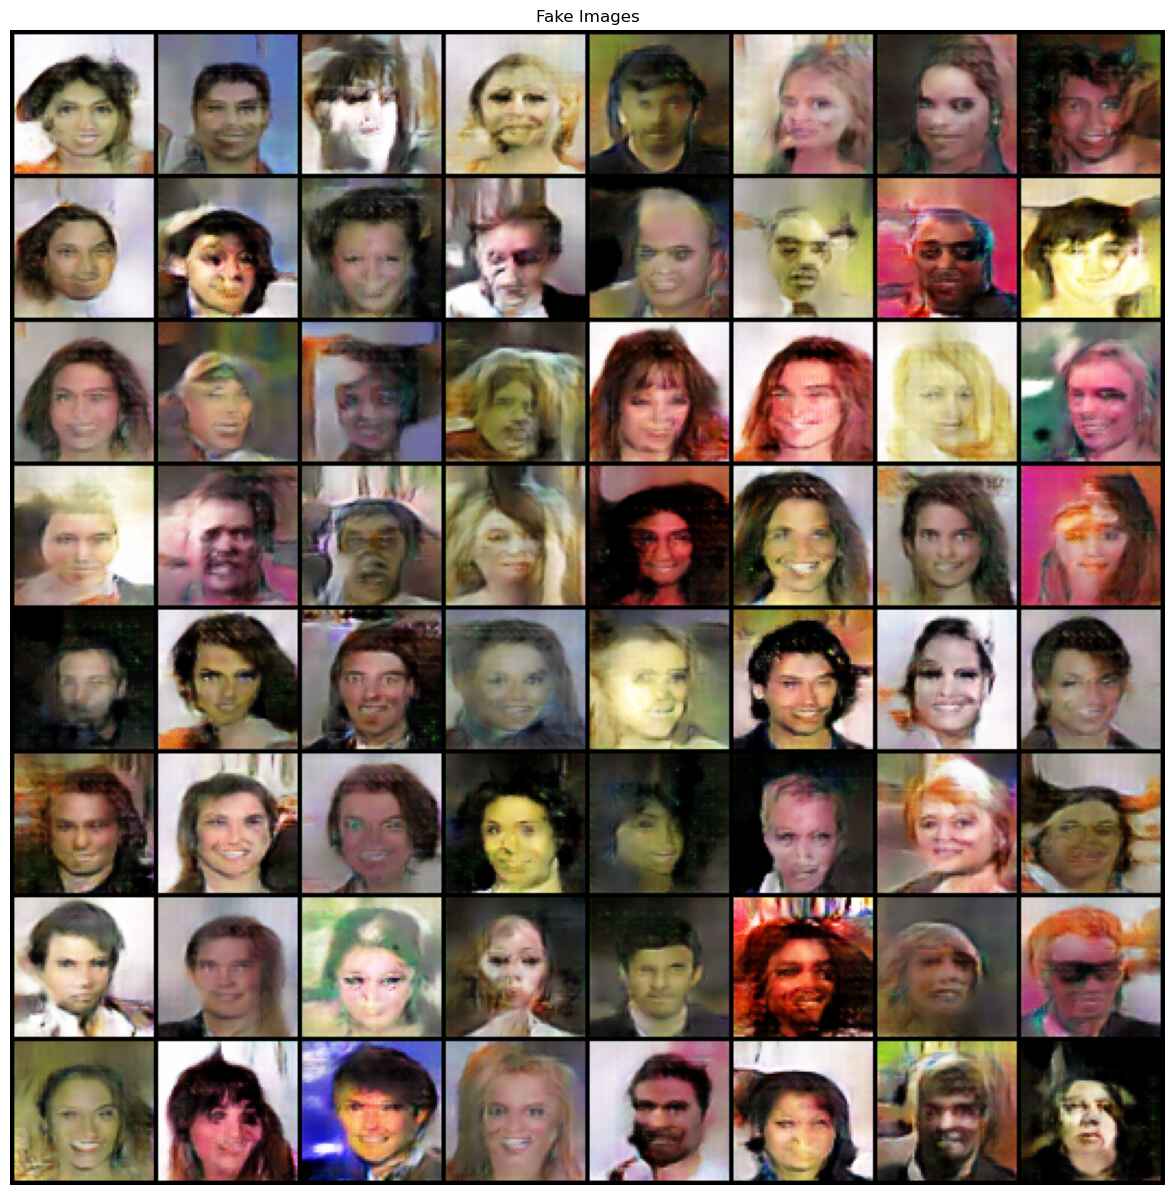

In [15]:
# Fake Images Grid 
#No Changes Needed
plt.figure(figsize=(15,15))
plt.subplot(1,1,1)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()